## Preprocess data

In [1]:
import pandas as pd
from mihm.data.process import multi_cat_to_one_hot, binary_to_one_hot, standardize_cols, convert_categorical_to_ordinal
from mihm.data.dataset import MIHMDataset

In [2]:
df = pd.read_stata('../HeatResilience.dta')
df.columns

Index(['pedlt1216', 'pedba1216', 'punem1216', 'pocmp1216', 'phpas1216',
       'pfvwc1216', 'ppv1216', 'mhval1216', 'mhinc1216', 'pmono', 'PNK_pct',
       'PBcell_pct', 'PCD8_Plus_pct', 'PCD4_Plus_pct', 'PNCD8_Plus_pct',
       'VBSI16WGTRA', 'age2016', 'female', 'racethn', 'mar2016', 'living2016',
       'eduy', 'work2016', 'chd2016', 'dep2016', 'adl2016', 'smoke2016',
       'bmi2016', 'psyche2016', 'stroke2016', 'hibpe2016', 'diabe2016',
       'hearte2016', 'drink2016', 'ltactx2016', 'mdactx2016', 'vgactx2016',
       'pm1yr', 'pm25_1', 'pm25_7', 'pm25_30', 'urban', 'mar_cat2', 'tractdis',
       'tractaff', 'ihs_wealthf2016', 'zPCPhenoAge_acc', 'zPCHorvath1_acc',
       'zPCHorvath2_acc', 'zPCHannum_acc', 'zPCGrimAge_acc',
       'zDunedinPACE_acc', 'division', 'm_HeatIndex_7d', 'm_HeatIndex_30d',
       'm_HeatIndex_90d', 'm_HeatIndex_1y', 'ch1_7d', 'ch1_30d', 'ch1_90d',
       'ch1_1y', 'ch2_7d', 'ch2_30d', 'ch2_90d', 'ch2_1y', 'resi_HI7d',
       'resi_Hlv17d'],
      dtype='o

In [3]:
# read model and rename cols
read_cols = ["zPCPhenoAge_acc", "m_HeatIndex_7d", "pm25_7", "age2016", "female", "racethn", "eduy", "ihs_wealthf2016", "pmono", "PNK_pct", 
            "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",
            "smoke2016", "drink2016", "bmi2016", "tractdis", "urban", "mar_cat2", "psyche2016", "stroke2016", "hibpe2016",
            "diabe2016", "hearte2016", "ltactx2016", "mdactx2016", "vgactx2016", "dep2016", "adl2016", 
            "living2016", "division"]

colname_dict = {
    "zPCPhenoAge_acc": "Pheno Age Accel.", 
    "m_HeatIndex_7d": "mean heat index over 7d", 
    "pm25_7": "pm2.5 over 7d",
    "age2016": "age", 
    "female": "female", 
    "racethn": "race/ethnicity", 
    "eduy": "education (in years)", 
    "ihs_wealthf2016": "household wealth (ihs)", 
    "smoke2016": "smoking status", 
    "drink2016": "drinking status", 
    "bmi2016": "bmi", 
    "tractdis": "tract disadvantage", 
    "urban": "urbanicity", 
    "mar_cat2": "marital status", 
    "psyche2016": "psychiatric conditions", 
    "stroke2016": "stroke", 
    "hibpe2016": "hypertension",
    "diabe2016": "diabetes", 
    "hearte2016": "heart disease", 
    "ltactx2016": "light activity", 
    "mdactx2016": "moderate activity", 
    "vgactx2016": "vigorous activity", 
    "dep2016": "depressive symptoms", 
    "adl2016": "adl limitations", 
    "living2016": "living alone", 
    "division": "census division"
}

df = pd.read_stata('../HeatResilience.dta', columns=read_cols)
df_orig = df.copy()
df.rename(columns=colname_dict, inplace=True)

In [4]:
# define model input variables
interactor_col = "mean heat index over 7d"
outcome_col = "Pheno Age Accel."
controlled_cols = [
    'mean heat index over 7d',
    "pmono",
    "PNK_pct",
    "PBcell_pct",
    "PCD8_Plus_pct",
    "PCD4_Plus_pct",
    "PNCD8_Plus_pct",
]
interaction_predictors = ['female', 'education (in years)', 'household wealth (ihs)', "pm2.5 over 7d",
'smoking status', 'drinking status', 'bmi', 'tract disadvantage',
'marital status', 'psychiatric conditions', 'stroke', 'hypertension',
'diabetes', 'heart disease', 'light activity', 'moderate activity',
'vigorous activity', 'depressive symptoms', 'adl limitations',
'living alone', 'race/ethnicity_0. NHW', 'race/ethnicity_1. NHB',
'race/ethnicity_2. Hispanic', 'race/ethnicity_3. Others',
'urbanicity_1. urban', 'urbanicity_2. suurban (code 2)',
'urbanicity_3. ex-urban', 'census division_Northeast',
'census division_Midwest', 'census division_South', 'census division_West']

In [5]:
# define variable types for preprocessing
categorical_cols = ['female', 'race/ethnicity', 'urbanicity', 'marital status', 'psychiatric conditions', 'stroke',
                    'hypertension', 'diabetes', 'heart disease', 'living alone', 'census division']
ordinal_cols = ['smoking status', 'drinking status', 'light activity', 'moderate activity', 'vigorous activity',]
continuous_cols = ['education (in years)', 'household wealth (ihs)', 'age', 'bmi', "pm2.5 over 7d",
                   'tract disadvantage', 'depressive symptoms', 'adl limitations', 'mean heat index over 7d',
                    'pmono', "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct", "Pheno Age Accel."]

In [6]:
for c in categorical_cols:
    df[c] = df[c].astype("category")
binary_cats = [c for c in categorical_cols if df[c].nunique() <=2]
multi_cats = [c for c in categorical_cols if df[c].nunique() > 2]

In [7]:
# make dataset
heat_dataset = MIHMDataset(df, interactor_col, controlled_cols, interaction_predictors, outcome_col)

In [8]:
# preprocess data
preprocess_list = [(binary_cats, binary_to_one_hot), 
                   (multi_cats, multi_cat_to_one_hot), 
                   (ordinal_cols, convert_categorical_to_ordinal)]

standardize_list = [(continuous_cols+ordinal_cols, standardize_cols)]

heat_dataset.preprocess(preprocess_list, inplace=True)
heat_dataset.standardize(standardize_list, inplace=True)
heat_dataset.dropna(inplace=True)

In [9]:
print("Total number of samples: ", len(heat_dataset))

Total number of samples:  3316


In [10]:
print("Mean and std of standardized predictors: ", heat_dataset.mean_std_dict)

Mean and std of standardized predictors:  {'education (in years)': (12.883308270676691, 3.1342179862584296), 'household wealth (ihs)': (5.4090805, 8.371072), 'age': (70.04451127819549, 9.23433744595856), 'bmi': (28.84815, 6.218937), 'pm2.5 over 7d': (8.290738, 2.6890137), 'tract disadvantage': (-0.012159855, 0.94902503), 'depressive symptoms': (1.3756391, 1.9412107), 'adl limitations': (0.13142857, 0.5505619), 'mean heat index over 7d': (74.170525, 18.664015), 'pmono': (8.56896240601504, 2.425775207038868), 'PNK_pct': (0.09263381460765885, 0.05817143127709421), 'PBcell_pct': (0.06956864196926095, 0.05356930770984166), 'PCD8_Plus_pct': (0.2503239019150917, 0.12165371343251581), 'PCD4_Plus_pct': (0.6766124278740906, 0.13978046436234295), 'PNCD8_Plus_pct': (0.22016338784150424, 0.15927694059686853), 'Pheno Age Accel.': (-0.014999974, 0.99856097), 'smoking status': (0.676390977443609, 0.6654162517744427), 'drinking status': (0.4592481203007519, 0.6107067477432152), 'light activity': (2.361

### Split data into train test validation set 

In [11]:
from mihm.data.trainutils import train_test_val_split
from torch.utils.data import DataLoader
import torch

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device="cpu"

In [13]:
train_idx, test_idx, val_idx = train_test_val_split(len(heat_dataset))
print("Train size: ", len(train_idx))
print("Test size: ", len(test_idx))
print("Val size: ", len(val_idx))

Train size:  1658
Test size:  829
Val size:  829


In [14]:
train_heat_dataset = heat_dataset.get_subset(train_idx)
test_heat_dataset = heat_dataset.get_subset(test_idx)
val_heat_dataset = heat_dataset.get_subset(val_idx)

In [15]:
# create dataset
train_dataset = train_heat_dataset.to_torch_dataset(device=device)
dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)

In [16]:
#dim reduction using PCA
interaction_vars_np = heat_dataset.df[heat_dataset.interaction_predictors].to_numpy()
k_dim = 28
U, S, V = torch.pca_lowrank(torch.from_numpy(interaction_vars_np), q=k_dim, center=False, niter=10)
V = V.to(torch.float32)
V.requires_grad = False

### Train

In [17]:
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import AdamW
import pyro
import torch.nn as nn
from mihm.model.bayes_mihm import BayesMIHM
from mihm.data.trainutils import get_mse_loss


In [18]:
interaction_var_size = train_heat_dataset.interaction_predictors.__len__()
controlled_var_size = train_heat_dataset.controlled_predictors.__len__()
hidden_layer_sizes = [50, 10, 1]
model = BayesMIHM(interaction_var_size, controlled_var_size, hidden_layer_sizes,
                  svd=True, svd_matrix=V, k_dim=k_dim, include_interactor_bias=True, device=device)
if device == "cuda":
    model.cuda()

In [19]:
guide = AutoMultivariateNormal(model)
optim = AdamW({"lr": 0.001, "weight_decay": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
epochs = 500
mseLoss = nn.MSELoss()

In [20]:
#set seed
torch.manual_seed(0)

In [27]:
for epoch in range(epochs):
    loss = 0
    train_dataset_torch = train_heat_dataset.to_tensor(device=device)
    test_dataset_torch = test_heat_dataset.to_tensor(device=device)
    for batch_idx, sample in enumerate(dataloader):
        loss += svi.step(sample["interaction_predictors"], sample["interactor"], sample["controlled_predictors"], y=sample["outcome"])
        loss /= len(dataloader.dataset)
        mse_loss, _ = get_mse_loss(model, train_dataset_torch["interaction_predictors"][0:300], train_dataset_torch["interactor"][0:300], train_dataset_torch["controlled_predictors"][0:300], train_dataset_torch["outcome"][0:300], guide)
        print(f"Epoch {epoch+1} : ELBO loss = {loss}, MSE loss = {mse_loss}")
        test_loss, pred_summary = get_mse_loss(model, test_dataset_torch["interaction_predictors"], test_dataset_torch["interactor"], test_dataset_torch["controlled_predictors"], test_dataset_torch["outcome"], guide)
        print(f"Test loss: {test_loss}")

AttributeError: 'dict' object has no attribute 'to_tensor'

In [ ]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    if name == "AutoMultivariateNormal.loc":
        print(name, value, value.shape)

NameError: name 'guide' is not defined

In [ ]:
coeffs = guide.quantiles([0.25, 0.5, 0.75])
coeffs

NameError: name 'guide' is not defined

In [ ]:
heat_dataset.mean_std_dict

{'education (in years)': (12.883308270676691, 3.1342179862584296),
 'household wealth (ihs)': (5.4090805, 8.371072),
 'age': (70.04451127819549, 9.23433744595856),
 'bmi': (28.84815, 6.218937),
 'tract disadvantage': (-0.012159855, 0.94902503),
 'depressive symptoms': (1.3756391, 1.9412107),
 'adl limitations': (0.13142857, 0.5505619),
 'mean heat index over 7d': (74.170525, 18.664015),
 'pmono': (8.56896240601504, 2.425775207038868),
 'PNK_pct': (0.09263381460765885, 0.05817143127709421),
 'PBcell_pct': (0.06956864196926095, 0.05356930770984166),
 'PCD8_Plus_pct': (0.2503239019150917, 0.12165371343251581),
 'PCD4_Plus_pct': (0.6766124278740906, 0.13978046436234295),
 'PNCD8_Plus_pct': (0.22016338784150424, 0.15927694059686853),
 'Pheno Age Accel.': (-0.014999974, 0.99856097),
 'smoking status': (0.676390977443609, 0.6654162517744427),
 'drinking status': (0.4592481203007519, 0.6107067477432152),
 'light activity': (2.3615037593984964, 1.1018353140678592),
 'moderate activity': (2.0390

In [ ]:
coeffs["interactor_bias"].numpy()[1]*heat_dataset.mean_std_dict["mean heat index over 7d"][1] + heat_dataset.mean_std_dict["mean heat index over 7d"][0]

array([96.300415], dtype=float32)

## Model prediction

In [ ]:
from mihm.model.mihm import IndexPredictionModel
import matplotlib.pyplot as plt

In [ ]:
model_name = "Feb23_heat_model_bnn_linear_svd_with_heat_bias_airpollution"
hidden_layer_sizes = [50, 10, 1]
interaction_var_size = train_heat_dataset.interaction_predictors.__len__()
model_index = IndexPredictionModel(interaction_var_size, hidden_layer_sizes, 
                             svd=True, svd_matrix=V.cuda(), k_dim=k_dim)
state_dict = torch.load('../checkpoints/{}.pth'.format(model_name))
model_index.load_state_dict(state_dict)
model_index.cuda().eval()

IndexPredictionModel(
  (layers): ModuleList(
    (0): Linear(in_features=28, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
# get all interaction vars from the dataset
all_interaction_vars_tensor = heat_dataset.to_tensor(device="cuda")["interaction_predictors"]
predicted_index = model_index(all_interaction_vars_tensor)
all_resilience_index = predicted_index.detach().cpu().numpy()

(array([  1.,   2.,   0.,   3.,   3.,  13.,  14.,  16.,  18.,  26.,  44.,
         49.,  69.,  69.,  67., 100., 104., 139., 158., 164., 215., 219.,
        213., 218., 200., 198., 175., 174., 146., 122.,  96.,  77.,  57.,
         42.,  34.,  16.,  14.,  13.,  10.,   8.,   4.,   2.,   4.,   2.,
          1.,   2.,   2.,   0.,   1.,   1.]),
 array([-0.26181841, -0.25481501, -0.24781159, -0.24080817, -0.23380476,
        -0.22680135, -0.21979794, -0.21279454, -0.20579113, -0.19878772,
        -0.19178431, -0.1847809 , -0.17777748, -0.17077407, -0.16377066,
        -0.15676725, -0.14976384, -0.14276043, -0.13575701, -0.12875362,
        -0.1217502 , -0.11474679, -0.10774338, -0.10073997, -0.09373656,
        -0.08673315, -0.07972974, -0.07272632, -0.06572291, -0.0587195 ,
        -0.0517161 , -0.04471269, -0.03770927, -0.03070586, -0.02370245,
        -0.01669904, -0.00969563, -0.00269222,  0.00431119,  0.0113146 ,
         0.01831801,  0.02532142,  0.03232483,  0.03932824,  0.04633165,
 

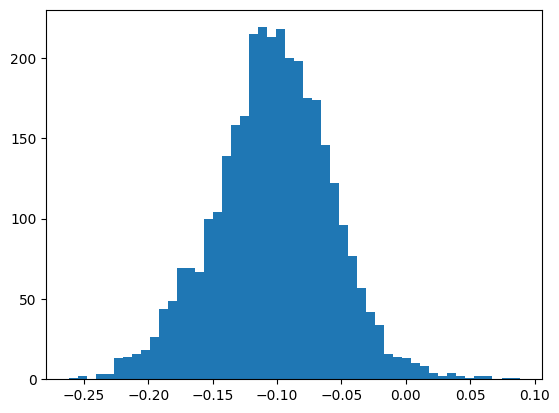

In [ ]:
plt.hist(all_resilience_index, bins=50)

In [ ]:
df_orig["vul_index"] = all_resilience_index
df_orig.to_stata("../data/HeatResilience_with_vul_index_model_{}.dta".format(model_name), write_index=False)

## Model Analysis using Shapley values

In [ ]:
import shap
import matplotlib.pyplot as plt
shap.initjs()

In [ ]:
explainer = shap.DeepExplainer(model_index, all_interaction_vars_tensor)

In [ ]:
shap_values = explainer.shap_values(all_interaction_vars_tensor[:1000], check_additivity=False)

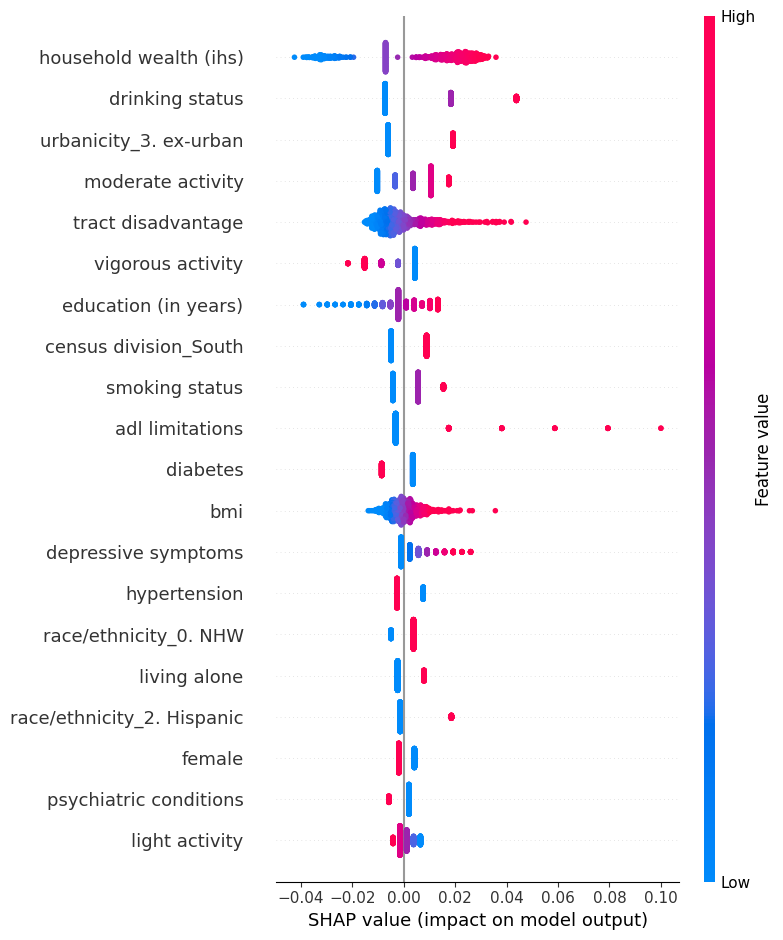

In [ ]:
shap.summary_plot(shap_values[:, :], all_interaction_vars_tensor[:1000, :].detach().cpu().numpy(), feature_names=interaction_predictors, show=False)
plt.savefig("../figures/Feb23_{}_1.png".format(model_name), dpi=300, bbox_inches="tight")